# QAQC Plot for LARGEEE

Note: Change `table_name` in "Load Data" Section before running notebook (they are marked with TODO)

## Import modules

In [76]:
import pandas as pd
from pathlib import Path

# from buildstock_query import BuildStockQuery
import qaqc_helper

## Constants & Funcs

In [77]:
output_dir = Path(".").resolve() / "data" / "output"
output_dir.mkdir(parents=True, exist_ok=True)


## Download data

In [78]:
### run CLI to see what's available
!aws s3 ls largeee/test_runs/

                           PRE baseline_20230525/
                           PRE cateory_2_20230525/
                           PRE cateory_3_20230525/
                           PRE cateory_4_20230525/
2023-05-20 19:37:05          0 


In [79]:
table_name = "baseline_20230525" #"cateory_2_20230525" # <---- TODO: specify table for download
s3_prefix = f"test_runs/{table_name}/" 

data_dir = qaqc_helper.s3_download.get_localdir_for_run(s3_prefix)
qaqc_helper.s3_download.download_s3_files(s3_prefix, destination=data_dir)

Data directory: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/baseline_20230525
/Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/baseline_20230525 files exist, no downloading


### Load

In [80]:
N_UNITS = 136569411
table_name = "cateory_2_20230525" # <--- folder containing upgrades only 
data_dir = qaqc_helper.s3_download.get_localdir_for_run(table_name)
baseline_data_dir = Path(".").resolve() / "data" / "baseline_20230525" # <--- TODO: make sure baseline is correct
print(f"baseline_data_dir: {baseline_data_dir}")

Data directory: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/cateory_2_20230525
baseline_data_dir: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/baseline_20230525


#### 1. Load baseline and upgrades
Invalid means upgrades does not apply

In [81]:
dfb, DFU = qaqc_helper.load_process.load_baseline_and_upgrades(data_dir, baseline_data_dir=baseline_data_dir, success_only=True)
dfb


        Returned output is: 
            first output: baseline dataframe
            second output: dictionary of upgrade packages, with key = upgrade_name and value = upgrade dataframe
        
Baseline: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade Thin Triple Windows: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade EnergyStar Windows: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade Light Touch Envelope: completed_status
Fail          7
Invalid    1793
Success    8138
Name: building_id, dtype: int64
Upgrade Intermediate Envelope: completed_status
Fail          7
Invalid     322
Success    9609
Name: building_id, dtype: int64
Upgrade Advanced Enclosure: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64


,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,build_existing_model.applicable,...,report_utility_bills.bills_propane_fixed_usd,report_utility_bills.bills_propane_total_usd,report_utility_bills.bills_total_usd,report_utility_bills.bills_wood_cord_energy_usd,report_utility_bills.bills_wood_cord_fixed_usd,report_utility_bills.bills_wood_cord_total_usd,report_utility_bills.bills_wood_pellets_energy_usd,report_utility_bills.bills_wood_pellets_fixed_usd,report_utility_bills.bills_wood_pellets_total_usd,report_utility_bills.output_format
building_id,,,,,,,,,,,,,,,,,,,,,
1,1,2023-05-25 14:26:36,2023-05-25 14:26:50,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2169.04,0.0,0.0,0.0,0.0,0.0,0.0,csv
2,1,2023-05-25 15:11:31,2023-05-25 15:11:44,Success,NaN,NaN,,Non-CBSA Pacific,No,True,...,0.0,0.0,3734.08,0.0,0.0,0.0,0.0,0.0,0.0,csv
3,1,2023-05-25 14:26:53,2023-05-25 14:27:05,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1637.84,0.0,0.0,0.0,0.0,0.0,0.0,csv
4,1,2023-05-25 14:28:34,2023-05-25 14:28:45,Success,NaN,NaN,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,True,...,0.0,0.0,1037.90,0.0,0.0,0.0,0.0,0.0,0.0,csv
5,1,2023-05-25 15:09:40,2023-05-25 15:09:51,Success,NaN,NaN,,Non-CBSA South Atlantic,No,True,...,0.0,0.0,1991.22,0.0,0.0,0.0,0.0,0.0,0.0,csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1,2023-05-25 15:32:20,2023-05-25 15:32:34,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1835.94,0.0,0.0,0.0,0.0,0.0,0.0,csv
9997,1,2023-05-25 14:45:20,2023-05-25 14:45:35,Success,NaN,NaN,,Non-CBSA East South Central,No,True,...,0.0,0.0,2001.40,0.0,0.0,0.0,0.0,0.0,0.0,csv
9998,1,2023-05-25 15:07:33,2023-05-25 15:07:47,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2221.43,0.0,0.0,0.0,0.0,0.0,0.0,csv


In [82]:
### Add bill calc
dfb, csd_cols = qaqc_helper.load_process.add_consolidated_columns(dfb)

for upg, df in DFU.items():
    DFU[upg] = df

data = dfb.groupby(["tenure", "fpl"])["report_simulation_output.energy_use_total_m_btu"]
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

mean == NAN indicates inf values exist


count        mean    median       p5        p95
tenure        fpl                                                           
Not Available Not Available    583   32.977882   25.3680   5.9659   83.16810
Owner         0-200%           465   76.736690   65.0350  29.7148  157.89460
              200-400%        1622  127.968106  109.9215  45.3515  277.48875
              400%+           4812  127.551645  111.3795  44.8052  254.78795
Renter        0-200%          1159   66.313207   54.5810  20.7614  148.90280
              200-400%         639   73.873346   63.5300  25.3327  158.40490
              400%+            651   64.304688   53.8390  19.8960  136.66950

In [83]:
data = dfb.groupby(["tenure", "lmi"])["report_utility_bills.bills_total_usd"]
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

mean == NAN indicates inf values exist


count         mean    median         p5  \
tenure        lmi                                                      
Not Available Not Available    583   906.835849   804.260   356.8250   
Owner         0-80%            601  2107.759601  1916.940  1136.9800   
              120%+           4944  2784.115639  2476.245  1406.2480   
              80-120%         1354  2760.660089  2403.665  1367.7565   
Renter        0-80%           1472  1696.185523  1555.115   836.1495   
              120%+            425  1936.349388  1773.390   902.5160   
              80-120%          552  1859.216232  1725.180   944.6785   

                                   p95  
tenure        lmi                       
Not Available Not Available  1824.1230  
Owner         0-80%          3669.9700  
              120%+          5099.3165  
              80-120%        5363.6365  
Renter        0-80%          3048.7860  
              120%+          3464.7720  
              80-120%        3245.5495

### G1. Baseline fuel use

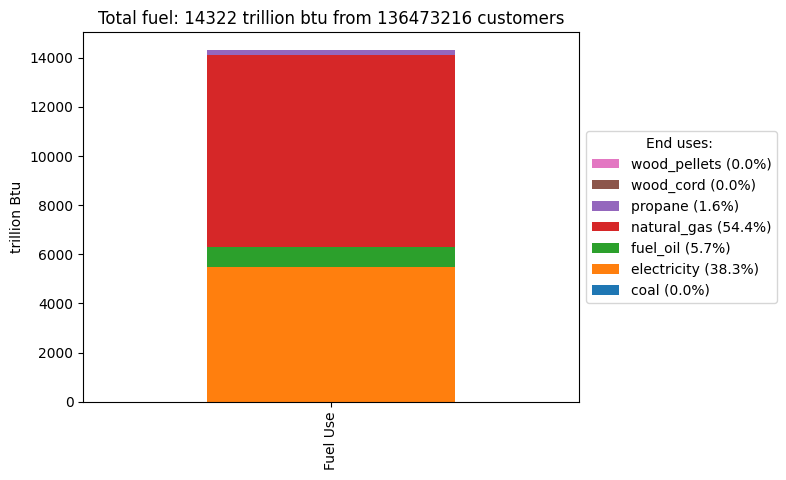

In [130]:
qaqc_helper.plot.plot_normalized_stacked_fuel_uses(dfb, n_represented="auto") # "auto" or N_UNITS


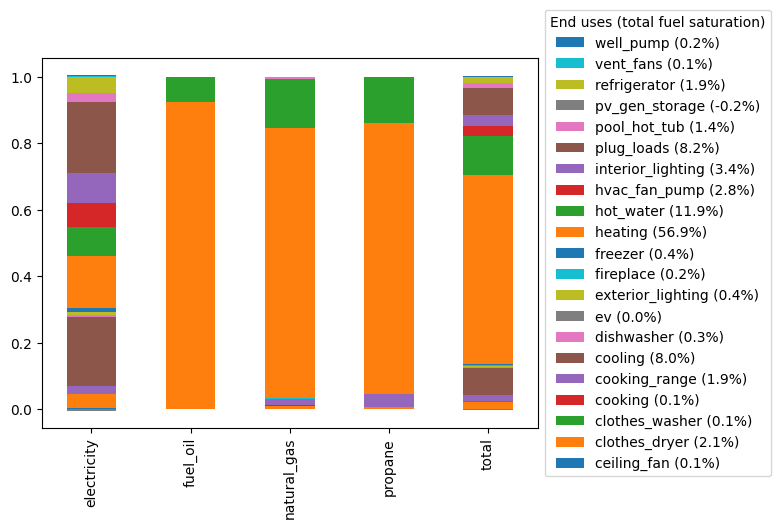

In [131]:
qaqc_helper.plot.plot_normalized_stacked_end_uses_by_fuel(dfb)

-- Dwelling Unit Electricity [kWh] --
count     9931.000000
mean     11778.060417
std       7819.686343
min        423.487696
25%       6485.662779
50%       9816.708561
75%      15059.603467
max      79405.554919
Name: report_simulation_output.fuel_use_electricity_total_m_btu, dtype: float64


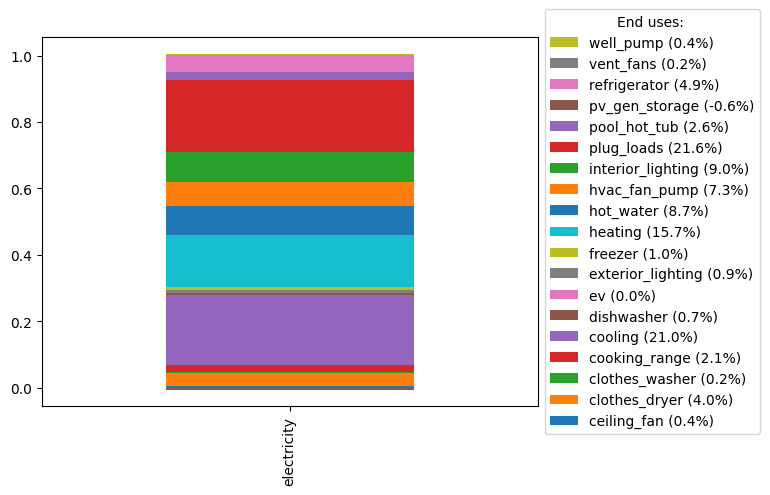

In [132]:
print("-- Dwelling Unit Electricity [kWh] --")
print((dfb["report_simulation_output.fuel_use_electricity_total_m_btu"]*MBTU_TO_KWH).describe())

qaqc_helper.plot.plot_normalized_stacked_end_uses(dfb, fuel="electricity")

### G2. Savings

In [ ]:
### check what's available based on key word
key_word = "electricity" # <---
[col for col in dfb.columns if key_word in col]

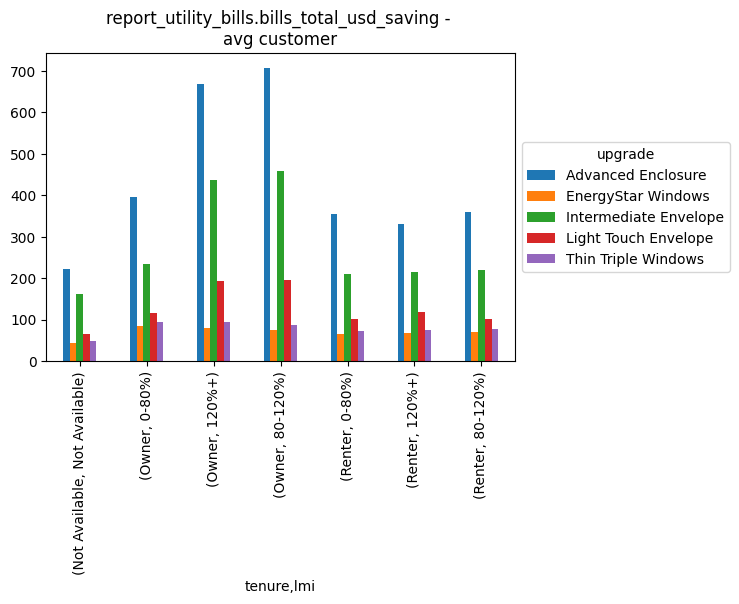

In [134]:
metric = "report_utility_bills.bills_total_usd" #"report_simulation_output.energy_use_total_m_btu"
dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving")

groupby_cols = ["upgrade", "tenure", "lmi"] #NOTE: can add in: "dac",
qaqc_helper.plot.plot_aggregated_metric(dfs, groupby_cols , metric+"_saving", operation="mean")

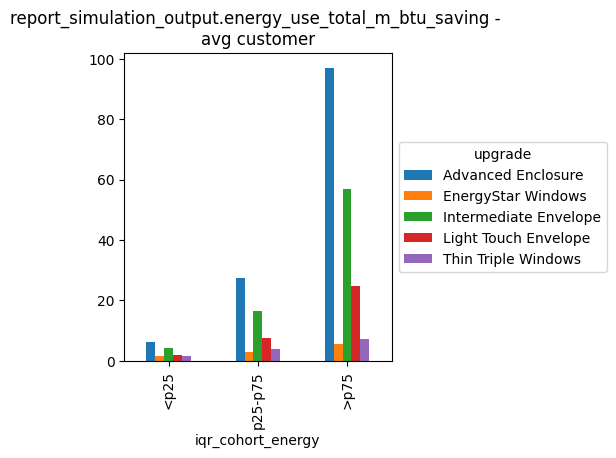

In [135]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"
dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving")

groupby_cols = ["upgrade", "iqr_cohort_energy"] # iqr_cohort_electricity
qaqc_helper.plot.plot_aggregated_metric(dfs, groupby_cols , metric+"_saving", operation="mean")

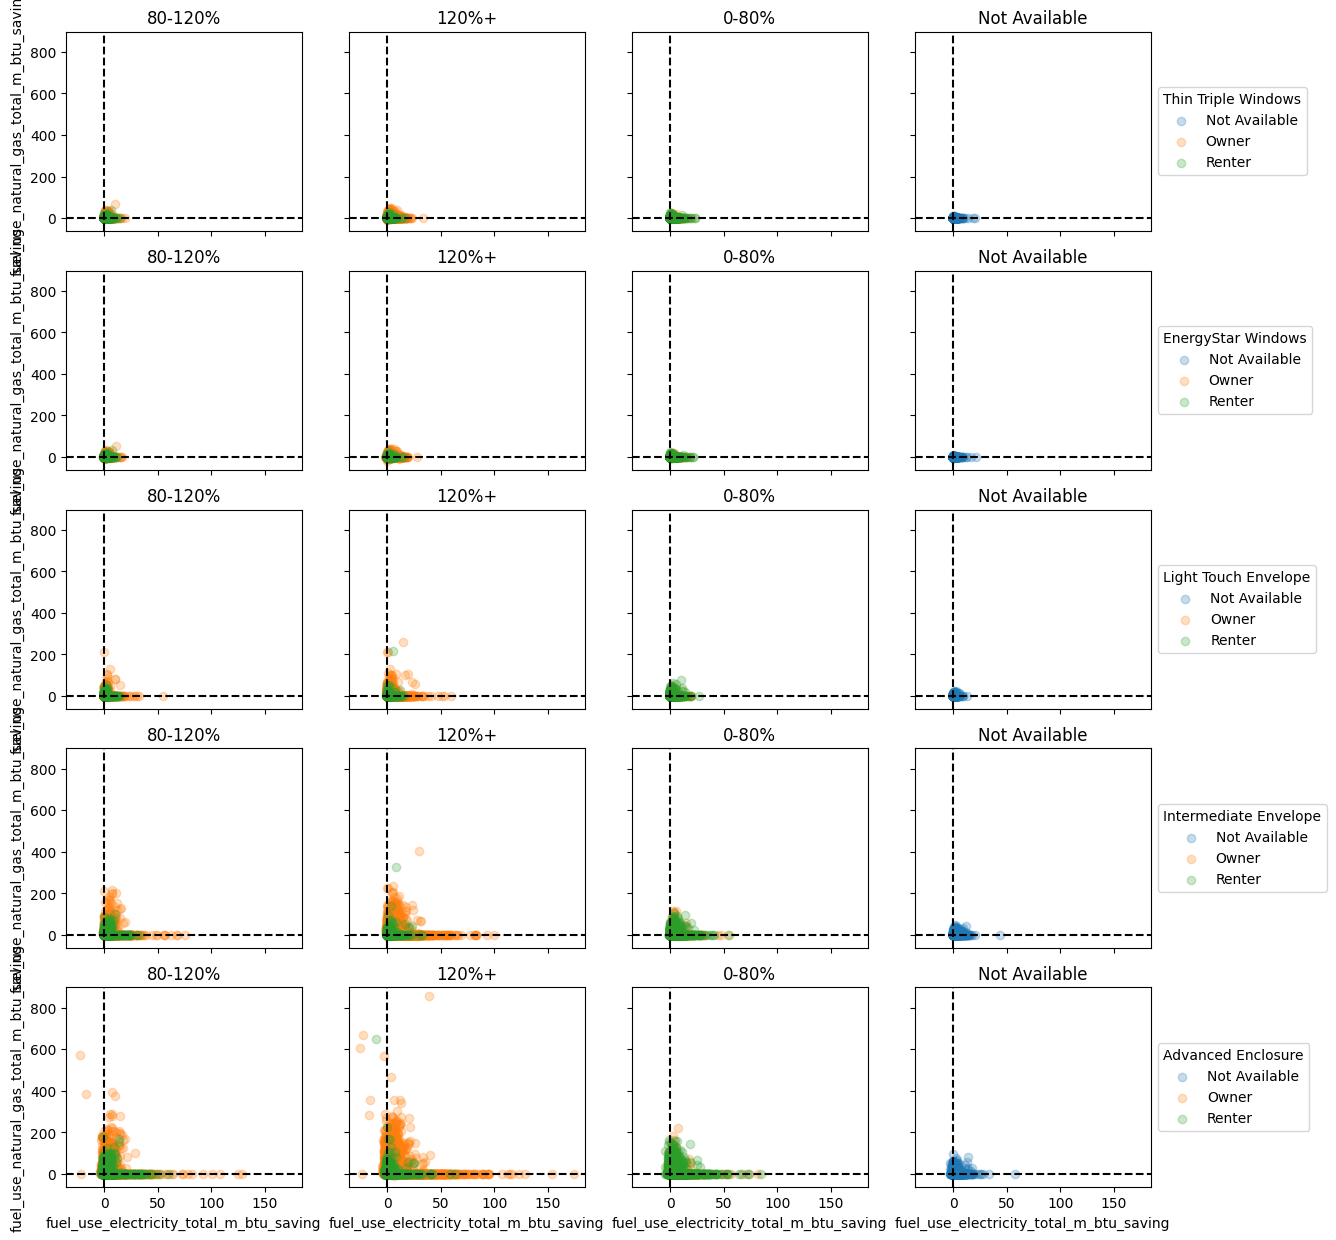

In [136]:
xmetric = "report_simulation_output.fuel_use_electricity_total_m_btu"
ymetric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "saving"
dfs = pd.concat([
    qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, xmetric, output_type=output_type),
    qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, ymetric, output_type=output_type, add_metadata=False)[ymetric+f"_{output_type}"]
], axis=1)

xmetric = xmetric+f"_{output_type}"
ymetric = ymetric+f"_{output_type}"
plot_row_by = "upgrade"
plot_column_by = "lmi"
groupby_cols = ["tenure"]

qaqc_helper.plot.plot_scatter(dfs, xmetric, ymetric, plot_row_by, plot_column_by, groupby_cols)

### G4. Histograms of bills and energy

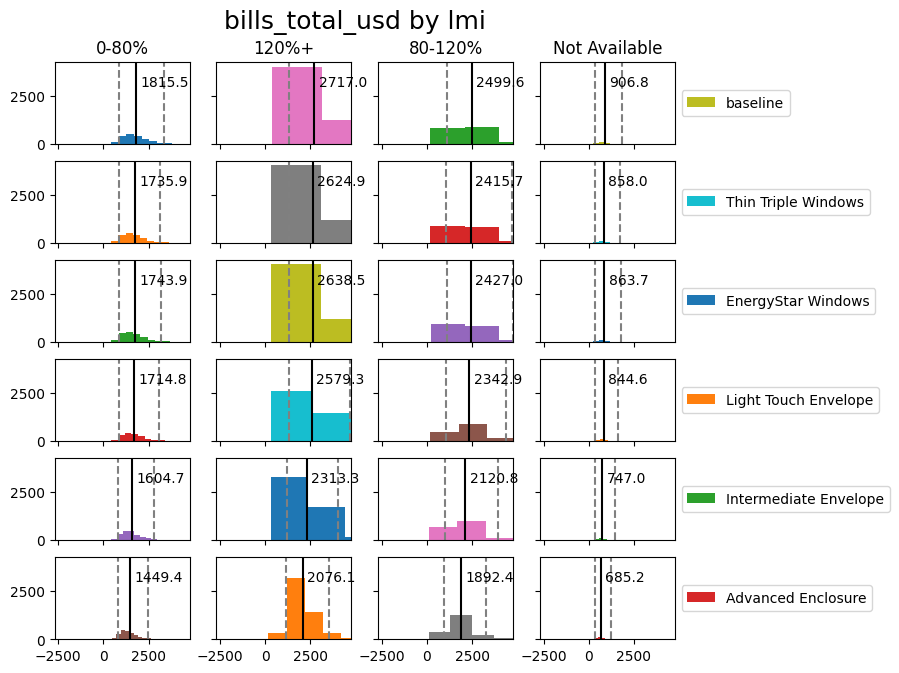

In [137]:
metric = "report_utility_bills.bills_total_usd" 
hc = "lmi" # "lmi", "tenure"
nbins = 20

# >10% severely burdened, 10-6% moderately burdened

qaqc_helper.plot.plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

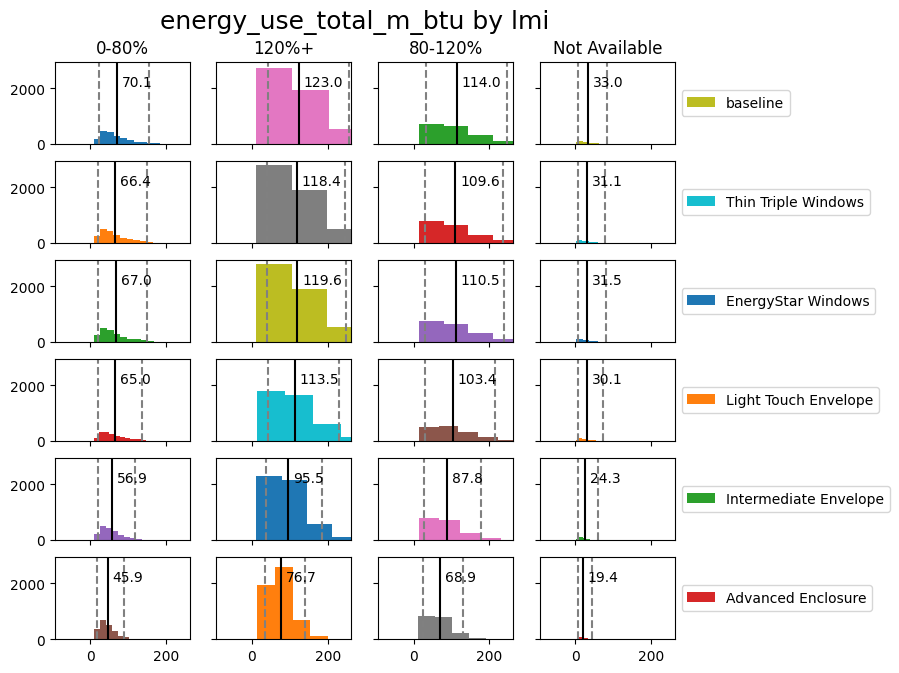

In [215]:
metric = "report_simulation_output.energy_use_total_m_btu"
hc = "lmi" # "lmi", "tenure"
nbins = 20

# >10% severely burdened, 10-6% moderately burdened

qaqc_helper.plot.plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

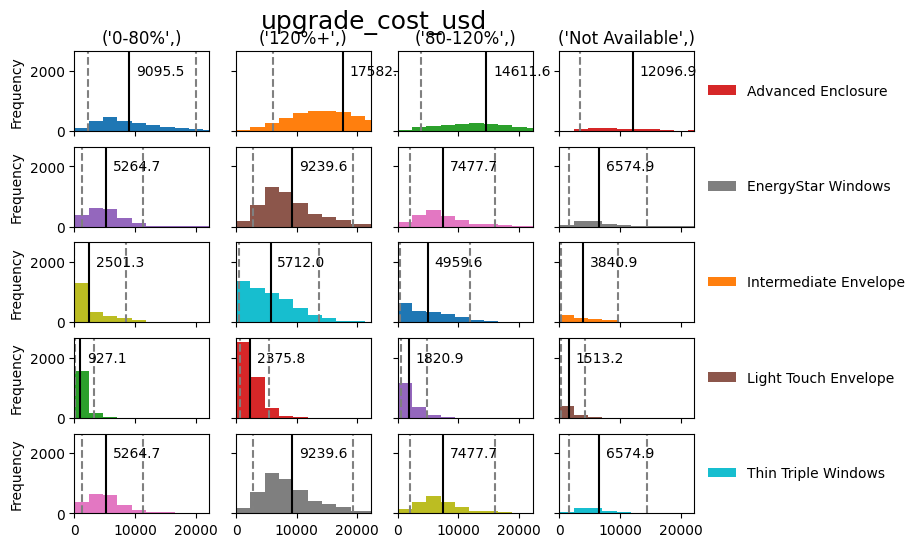

In [199]:
metric = "upgrade_costs.upgrade_cost_usd"
output_type = None
hc = ["upgrade", "lmi"] # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 50

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric, hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

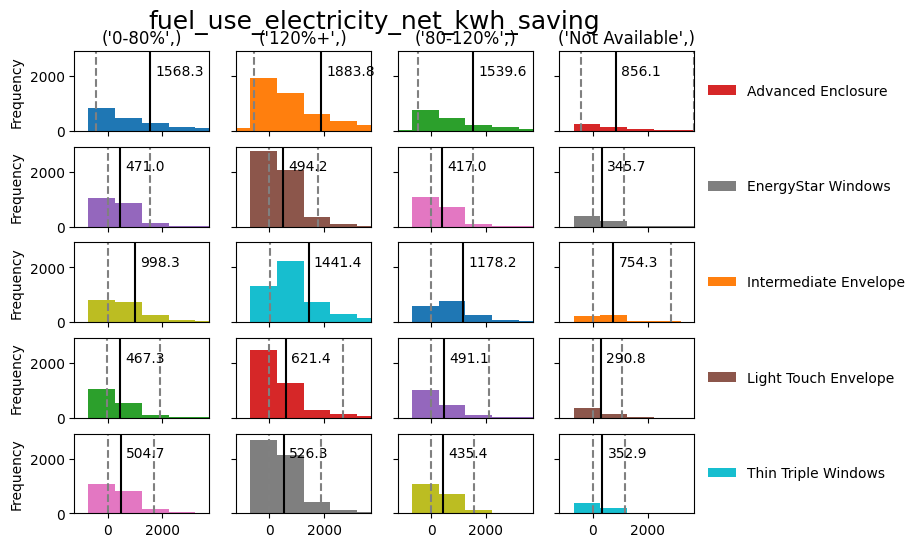

In [220]:
metric = "report_simulation_output.fuel_use_electricity_net_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade", "lmi"] # "lmi", "tenure"
nbins = 60

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")